# 確率的グラフィカルモデルの美しい視覚化を作成する方法
http://num.pyro.ai/en/latest/tutorials/model_rendering.html

!pip install -q numpyro@git+https://github.com/pyro-ppl/numpyro でinstall しないとnumpyro.render_model は使えない！！！

In [1]:
from jax import nn
import jax.numpy as jnp

import numpyro
import numpyro.distributions as dist

assert numpyro.__version__.startswith('0.6.0')

In [2]:
numpyro.set_platform("cpu")

### 簡単な例

In [3]:
def model(data):
    m = numpyro.sample('m', dist.Normal(0, 1))
    sd = numpyro.sample('sd', dist.LogNormal(m, 1))
    with numpyro.plate('N', len(data)):
        numpyro.sample('obs', dist.Normal(m, sd), obs=data)

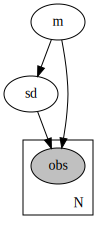

In [4]:
data = jnp.ones(10)
numpyro.render_model(model, model_args=(data,))

In [5]:
graph = numpyro.render_model(model, model_args=(data,), filename='model.pdf')

### グラフの視覚化をさらに改善

In [6]:
def mace(positions, annotations):
    """
    This model corresponds to the plate diagram in Figure 3 of https://www.aclweb.org/anthology/Q18-1040.pdf.
    """
    num_annotators = int(jnp.max(positions)) + 1
    num_classes = int(jnp.max(annotations)) + 1
    num_items, num_positions = annotations.shape

    with numpyro.plate('annotator', num_annotators):
        epsilon = numpyro.sample('epsilon', dist.Dirichlet(jnp.full(num_classes, 10)))
        theta = numpyro.sample('theta', dist.Beta(0.5, 0.5))

    with numpyro.plate('item', num_items, dim=-2):
        # NB: using constant logits for discrete uniform prior
        # (NumPyro does not have DiscreteUniform distribution yet)
        c = numpyro.sample('c', dist.Categorical(logits=jnp.zeros(num_classes)))

        with numpyro.plate('position', num_positions):
            s = numpyro.sample('s', dist.Bernoulli(1 - theta[positions]))
            probs = jnp.where(s[..., None] == 0, nn.one_hot(c, num_classes), epsilon[positions])
            numpyro.sample('y', dist.Categorical(probs), obs=annotations)

positions = jnp.array([1, 1, 1, 2, 3, 4, 5])
annotations = jnp.array([
    [1, 3, 1, 2, 2, 2, 1, 3, 2, 2, 4, 2, 1, 2, 1,
     1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1,
     1, 3, 1, 2, 2, 4, 2, 2, 3, 1, 1, 1, 2, 1, 2],
    [1, 3, 1, 2, 2, 2, 2, 3, 2, 3, 4, 2, 1, 2, 2,
     1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 3, 1, 1, 1,
     1, 3, 1, 2, 2, 3, 2, 3, 3, 1, 1, 2, 3, 2, 2],
    [1, 3, 2, 2, 2, 2, 2, 3, 2, 2, 4, 2, 1, 2, 1,
     1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 2, 1, 1, 2,
     1, 3, 1, 2, 2, 3, 1, 2, 3, 1, 1, 1, 2, 1, 2],
    [1, 4, 2, 3, 3, 3, 2, 3, 2, 2, 4, 3, 1, 3, 1,
     2, 1, 1, 2, 1, 2, 2, 3, 2, 1, 1, 2, 1, 1, 1,
     1, 3, 1, 2, 3, 4, 2, 3, 3, 1, 1, 2, 2, 1, 2],
    [1, 3, 1, 1, 2, 3, 1, 4, 2, 2, 4, 3, 1, 2, 1,
     1, 1, 1, 2, 3, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1,
     1, 2, 1, 2, 2, 3, 2, 2, 4, 1, 1, 1, 2, 1, 2],
    [1, 3, 2, 2, 2, 2, 1, 3, 2, 2, 4, 4, 1, 1, 1,
     1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 2,
     1, 3, 1, 2, 3, 4, 3, 3, 3, 1, 1, 1, 2, 1, 2],
    [1, 4, 2, 1, 2, 2, 1, 3, 3, 3, 4, 3, 1, 2, 1,
     1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1, 2, 1, 1, 1,
     1, 3, 1, 2, 2, 3, 2, 3, 2, 1, 1, 1, 2, 1, 2],
]).T

# we subtract 1 because the first index starts with 0 in Python
positions -= 1
annotations -= 1

mace_graph = numpyro.render_model(mace, model_args=(positions, annotations))

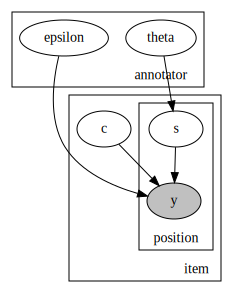

In [7]:
# default layout
mace_graph

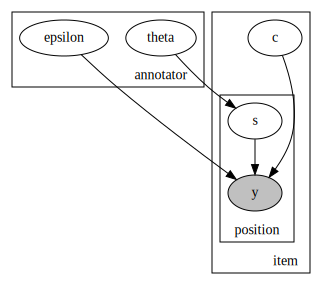

In [8]:
# layout after processing the layout with unflatten
mace_graph.unflatten(stagger=2)

### 分布の注釈

In [9]:
def model(data):
    x = numpyro.sample('x', dist.Normal(0, 1))
    y = numpyro.sample('y', dist.LogNormal(x, 1))
    with numpyro.plate('N', len(data)):
        numpyro.sample('z', dist.Normal(x, y), obs=data)

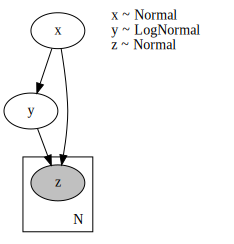

In [10]:
data = jnp.ones(10)
numpyro.render_model(model, model_args=(data,), render_distributions=True)